In [2]:
print("hi")

hi


In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:


# Paths 
trans_folder = 'C:/Users/asus/Downloads/val/val/trans'
hazy_folder = 'C:/Users/asus/Downloads/val/val/haze'
clear_folder = 'C:/Users/asus/Downloads/val/val/clear'

haze_files = sorted(os.listdir(hazy_folder))  # Ensure order
trans_files = sorted(os.listdir(trans_folder))
clear_files = sorted(os.listdir(clear_folder))

In [5]:

# Subset to 100 clear images (~1,000 hazy/trans)
clear_ids = [f.split(".")[0] for f in clear_files][:100]  # e.g., 10001-10100
hazy_files_subset = [f for f in haze_files if f.split("_")[0] in clear_ids][:1000]
trans_files_subset = [f for f in trans_files if f.split("_")[0] in clear_ids][:1000]
clear_files_subset = clear_files[:100]


Hazy: 10001_01_0.9797.png, Trans: 10001_01.png, Clear: 10001.png
Hazy: 10001_02_0.9221.png, Trans: 10001_02.png, Clear: 10001.png
Hazy: 10001_03_0.9784.png, Trans: 10001_03.png, Clear: 10001.png
Hazy: 10001_04_0.9066.png, Trans: 10001_04.png, Clear: 10001.png
Hazy: 10001_05_0.8052.png, Trans: 10001_05.png, Clear: 10001.png
Hazy images: 1000
Trans images: 1000
Clear images: 100


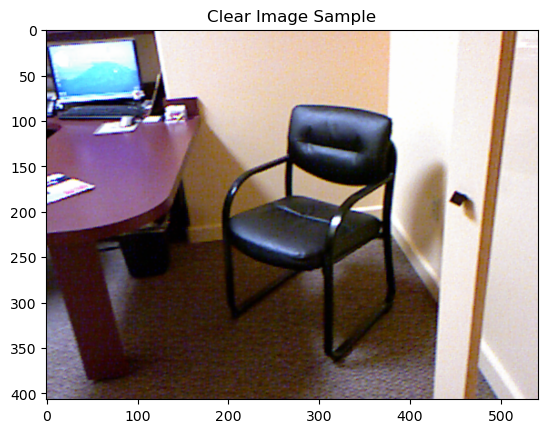

Subset verified with sorted mapping.


In [6]:
def load_images_from_folder(folder, file_list):
    images = []
    for filename in file_list:
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        images.append(np.array(img))
    return images

hazy_images = load_images_from_folder(hazy_folder, hazy_files_subset)
trans_images = load_images_from_folder(trans_folder, trans_files_subset)
clear_images = load_images_from_folder(clear_folder, clear_files_subset)

# Verify mapping (check first few)
for i in range(5):
    hazy_name = hazy_files_subset[i]
    trans_name = trans_files_subset[i]
    clear_name = clear_files_subset[i // 10]
    print(f"Hazy: {hazy_name}, Trans: {trans_name}, Clear: {clear_name}")

# Verify counts
print(f'Hazy images: {len(hazy_images)}')
print(f'Trans images: {len(trans_images)}')
print(f'Clear images: {len(clear_images)}')

# Visualize
plt.figure()
plt.imshow(clear_images[0])
plt.title("Clear Image Sample")
plt.show()

print("Subset verified with sorted mapping.")

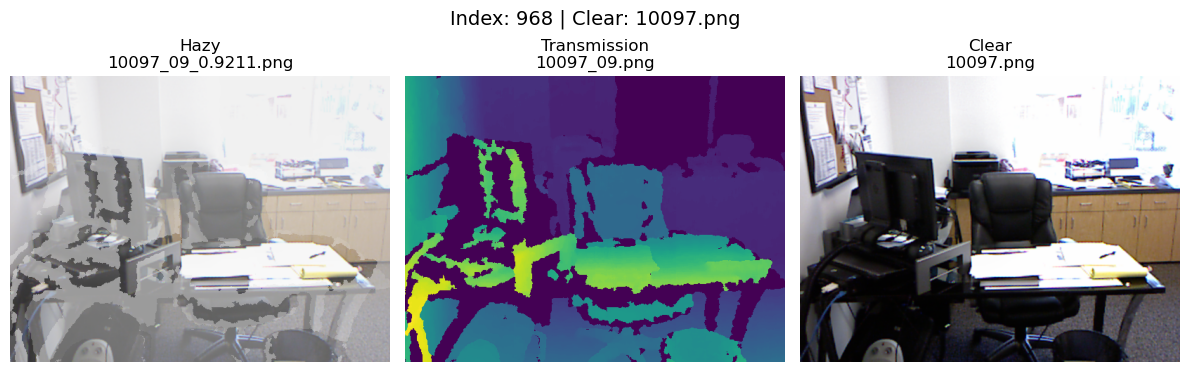

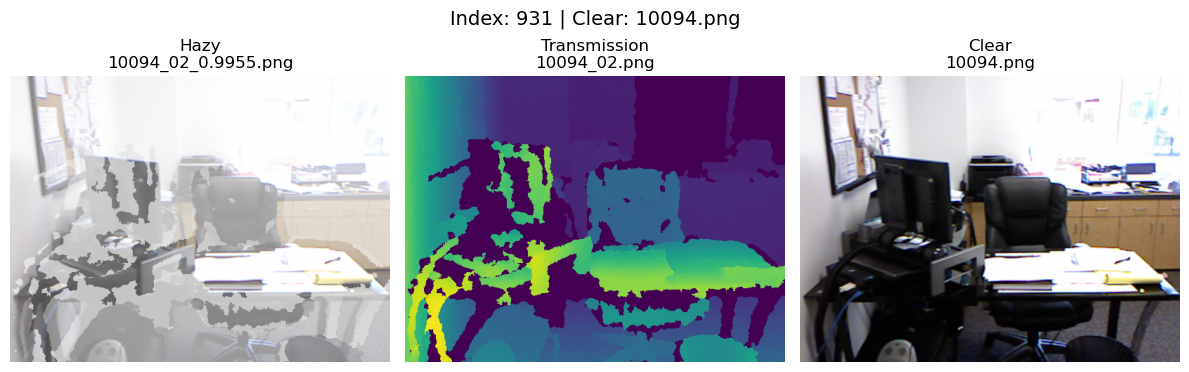

In [7]:
import random

# Pick two random indices
random_indices = random.sample(range(len(hazy_images)), 2)

for idx in random_indices:
    hazy_img = hazy_images[idx]
    trans_img = trans_images[idx]
    clear_img = clear_images[idx // 10]  # 10 hazy/trans : 1 clear

    hazy_name = hazy_files_subset[idx]
    trans_name = trans_files_subset[idx]
    clear_name = clear_files_subset[idx // 10]

    # Plot the images
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Index: {idx} | Clear: {clear_name}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(hazy_img)
    plt.title(f"Hazy\n{hazy_name}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(trans_img)
    plt.title(f"Transmission\n{trans_name}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(clear_img)
    plt.title(f"Clear\n{clear_name}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [8]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:

# Pre-process function
def preprocess_image(img):
    img = cv2.resize(img, (256, 256)).astype(np.float32) / 255.0
    img_uint8 = (img * 255).astype(np.uint8)
    smoothed = cv2.medianBlur(img_uint8, 5) / 255.0
    dark = cv2.erode(np.min(smoothed, axis=2), np.ones((15, 15)))
    num_pixels = int(0.001 * dark.size)
    indices = np.argpartition(dark.ravel(), -num_pixels)[-num_pixels:]
    A = np.mean(smoothed.reshape(-1, 3)[indices], axis=0)
    return smoothed, A


In [10]:


# Process images
smoothed_images = []
A_values = []
for img in hazy_images:
    smoothed, A = preprocess_image(img)
    smoothed_images.append(smoothed)
    A_values.append(A)


In [11]:

# Resize trans/clear
trans_images = [cv2.resize(img, (256, 256)).astype(np.float32) / 255.0 for img in trans_images]
clear_images = [cv2.resize(img, (256, 256)).astype(np.float32) / 255.0 for img in clear_images]

# Split 70% train, 30% test
train_idx, test_idx = train_test_split(range(len(smoothed_images)), train_size=0.7, random_state=42)

train_hazy = [smoothed_images[i] for i in train_idx]
train_trans = [trans_images[i] for i in train_idx]
test_hazy = [smoothed_images[i] for i in test_idx]
test_trans = [trans_images[i] for i in test_idx]
test_A = [A_values[i] for i in test_idx]
test_clear = [clear_images[i // 10] for i in test_idx]

# Clear memory
hazy_images = None
import gc
gc.collect()

print(f"Pre-processed {len(smoothed_images)} images.")
print(f"Train: {len(train_hazy)} hazy, Test: {len(test_hazy)} hazy")

Pre-processed 1000 images.
Train: 700 hazy, Test: 300 hazy


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [13]:

# Dataset
class DehazeDataset(Dataset):
    def __init__(self, hazy_images, trans_images):
        self.hazy_images = hazy_images
        self.trans_images = trans_images

    def __len__(self):
        return len(self.hazy_images)

    def __getitem__(self, idx):
        hazy = self.hazy_images[idx]
        trans = self.trans_images[idx]
        return (torch.tensor(hazy, dtype=torch.float32).permute(2, 0, 1),
                torch.tensor(trans, dtype=torch.float32).unsqueeze(0))


In [14]:

# U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Conv2d(96, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        p1 = self.pool(e1)
        e2 = self.relu(self.enc2(p1))
        u1 = self.up(e2)
        m1 = torch.cat([e1, u1], dim=1)
        d1 = self.relu(self.dec1(m1))
        return self.sigmoid(self.out(d1))

In [15]:


# DataLoaders
train_dataset = DehazeDataset(train_hazy, train_trans)
test_dataset = DehazeDataset(test_hazy, test_trans)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [16]:

# Train
model = UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cpu")
model.to(device)


UNet(
  (enc1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (dec1): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [17]:

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for hazy, trans in train_loader:
        hazy, trans = hazy.to(device), trans.to(device)
        optimizer.zero_grad()
        outputs = model(hazy)
        loss = criterion(outputs, trans)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * hazy.size(0)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for hazy, trans in test_loader:
            hazy, trans = hazy.to(device), trans.to(device)
            outputs = model(hazy)
            loss = criterion(outputs, trans)
            val_loss += loss.item() * hazy.size(0)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataset):.4f}, Val Loss: {val_loss/len(test_dataset):.4f}")

torch.save(model.state_dict(), "unet_dehaze_2k.pth")
print("Model trained.")

Epoch 1/10, Train Loss: 0.0239, Val Loss: 0.0203
Epoch 2/10, Train Loss: 0.0212, Val Loss: 0.0196
Epoch 3/10, Train Loss: 0.0205, Val Loss: 0.0189
Epoch 4/10, Train Loss: 0.0203, Val Loss: 0.0193
Epoch 5/10, Train Loss: 0.0200, Val Loss: 0.0203
Epoch 6/10, Train Loss: 0.0195, Val Loss: 0.0200
Epoch 7/10, Train Loss: 0.0198, Val Loss: 0.0193
Epoch 8/10, Train Loss: 0.0195, Val Loss: 0.0183
Epoch 9/10, Train Loss: 0.0195, Val Loss: 0.0192
Epoch 10/10, Train Loss: 0.0192, Val Loss: 0.0185
Model trained.


In [18]:

# Dehaze
dehazed_images = []
dehazed_enhanced = []

model.eval()
with torch.no_grad():
    for i, (hazy, _) in enumerate(test_loader):
        hazy = hazy.to(device)
        t_pred = model(hazy)
        
        A_batch = np.array(test_A[i*4:(i+1)*4])[:, None, None, :]
        hazy_np = hazy.permute(0, 2, 3, 1).cpu().numpy()
        t_pred_np = t_pred.permute(0, 2, 3, 1).cpu().numpy()
        
        dehazed = (hazy_np - A_batch) / np.maximum(t_pred_np, 0.1) + A_batch
        dehazed = np.clip(dehazed, 0, 1)
        
        for img in dehazed:
            img_uint8 = (img * 255).astype(np.uint8)
            img_denoised = cv2.bilateralFilter(img_uint8, d=9, sigmaColor=75, sigmaSpace=75)
            img_lab = cv2.cvtColor(img_denoised, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(img_lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l_clahe = clahe.apply(l)
            img_lab_clahe = cv2.merge((l_clahe, a, b))
            img_clahe = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2BGR)
            img_final = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
            dehazed_enhanced.append(img_final)
            dehazed_images.append(img)

print(f"Dehazed and enhanced {len(dehazed_enhanced)} images.")


Dehazed and enhanced 300 images.


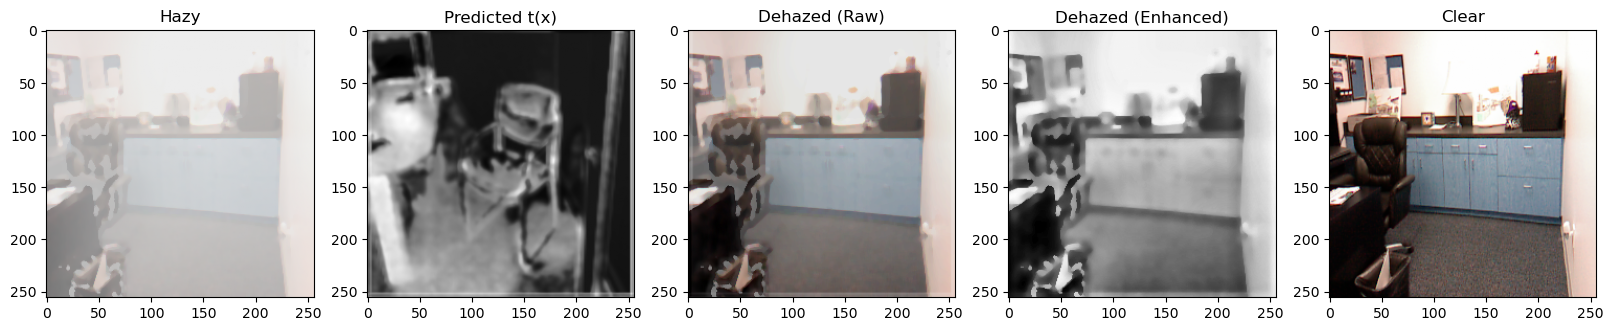

In [94]:

# Visualize index 90
image_idx = 90
plt.figure(figsize=(20, 5))
plt.subplot(151); plt.imshow(test_hazy[image_idx][..., ::-1]); plt.title("Hazy")
plt.subplot(152); plt.imshow(t_pred_np[image_idx % 4, ..., 0], cmap="gray"); plt.title("Predicted t(x)")
plt.subplot(153); plt.imshow(dehazed_images[image_idx][..., ::-1]); plt.title("Dehazed (Raw)")
plt.subplot(154); plt.imshow(dehazed_enhanced[image_idx], cmap="gray"); plt.title("Dehazed (Enhanced)")
plt.subplot(155); plt.imshow(test_clear[image_idx][..., ::-1]); plt.title("Clear")
plt.show()

In [58]:

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

psnr_scores = []
ssim_scores = []
for i in range(len(dehazed_images)):
    clear_img = test_clear[i]
    dehazed_img = dehazed_images[i]
    psnr = peak_signal_noise_ratio(clear_img * 255, dehazed_img * 255, data_range=255)
    ssim = structural_similarity(clear_img * 255, dehazed_img * 255, channel_axis=-1, data_range=255)
    psnr_scores.append(psnr)
    ssim_scores.append(ssim)

print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_scores):.3f}")

Average PSNR: 16.82 dB
Average SSIM: 0.625


In [80]:
def dehaze_single_image(input_img_path, model, device):
    import cv2
    import torch
    import numpy as np
    import matplotlib.pyplot as plt

    # === Step 1: Preprocessing ===
    img = cv2.imread(input_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (256, 256)).astype(np.float32) / 255.0

    img_uint8 = (img_resized * 255).astype(np.uint8)
    smoothed = cv2.medianBlur(img_uint8, 5).astype(np.float32) / 255.0

    dark = cv2.erode(np.min(smoothed, axis=2), np.ones((15, 15)))
    num_pixels = int(0.001 * dark.size)
    indices = np.argpartition(dark.ravel(), -num_pixels)[-num_pixels:]
    A = np.mean(smoothed.reshape(-1, 3)[indices], axis=0)
    A = A[None, None, :]

    input_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).unsqueeze(0).to(device)

    # === Step 2: Model Prediction ===
    model.eval()
    with torch.no_grad():
        t_pred = model(input_tensor)
        t_pred_np = t_pred.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # === Step 3: Dehazing ===
    hazy_np = img_resized
    t_pred_np = np.maximum(t_pred_np, 0.1)
    dehazed = (hazy_np - A) / t_pred_np + A
    dehazed = np.clip(dehazed, 0, 1)

    # === Step 4: Post-processing ===
    dehazed_uint8 = (dehazed * 255).astype(np.uint8)
    lab = cv2.cvtColor(dehazed_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced, -1, kernel_sharp)

    hsv = cv2.cvtColor(sharpened, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,1] = np.clip(hsv[...,1] * 1.1, 0, 255)
    boosted = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

    # === Step 5: Final Gentle Smoothening ===
    final_result = cv2.bilateralFilter(boosted, d=5, sigmaColor=50, sigmaSpace=50)

    # === Step 6: Display Results ===
    titles = ['Original Hazy', 'Preprocessed', 'Dehazed', 'Final Enhanced']
    images = [img_rgb, smoothed, dehazed, final_result]

    plt.figure(figsize=(14, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return dehazed, final_result


In [98]:


# Evaluate raw dehazed images (RGB)
psnr_scores = []
ssim_scores = []

for i in range(len(dehazed_images)):
    clear_img = test_clear[i] 
    dehazed_img = dehazed_images[i]
    psnr = peak_signal_noise_ratio(
        clear_img * 255, dehazed_img * 255, data_range=255
    )
    ssim = structural_similarity(
        clear_img * 255,
        dehazed_img * 255,
        channel_axis=-1,
        data_range=255,
        win_size=7
    )
    psnr_scores.append(psnr)
    ssim_scores.append(ssim)

avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)
print(f"Average PSNR (Raw): {avg_psnr:.2f} dB")
print(f"Average SSIM (Raw): {avg_ssim:.3f}")

# Evaluate enhanced grayscale images
psnr_enhanced = []
ssim_enhanced = []

for i in range(len(dehazed_enhanced)):
    clear_img = test_clear[i]
    clear_img_gray = cv2.cvtColor(
        (clear_img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY
    )
    enhanced_img = dehazed_enhanced[i]
    psnr = peak_signal_noise_ratio(clear_img_gray, enhanced_img, data_range=255)
    ssim = structural_similarity(
        clear_img_gray,
        enhanced_img,
        data_range=255,
        win_size=7
    )
    psnr_enhanced.append(psnr)
    ssim_enhanced.append(ssim)

avg_psnr_enhanced = np.mean(psnr_enhanced)
avg_ssim_enhanced = np.mean(ssim_enhanced)
print(f"Average PSNR (Enhanced): {avg_psnr_enhanced:.2f} dB")
print(f"Average SSIM (Enhanced): {avg_ssim_enhanced:.3f}")

Average PSNR (Raw): 16.82 dB
Average SSIM (Raw): 0.625
Average PSNR (Enhanced): 16.64 dB
Average SSIM (Enhanced): 0.626


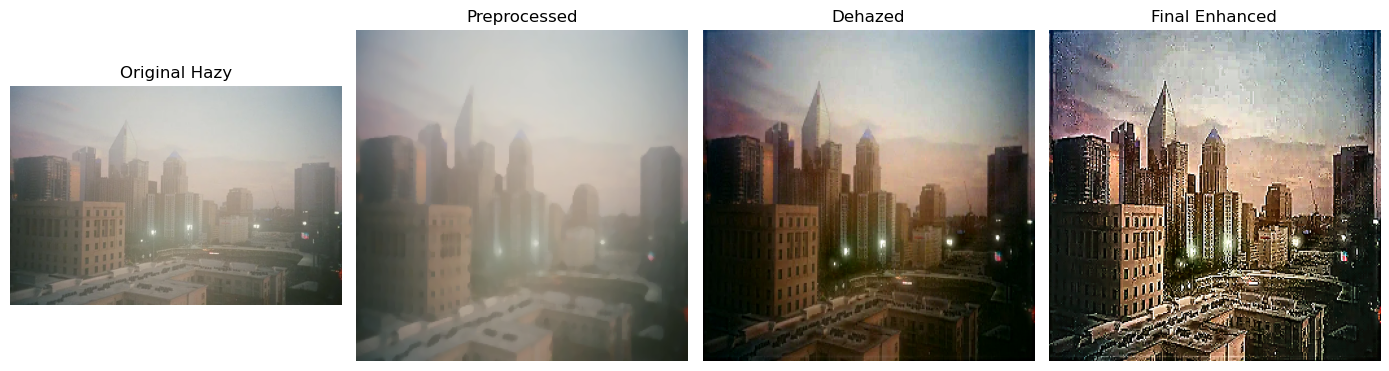

In [82]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\hazedimg1.webp", model, device)


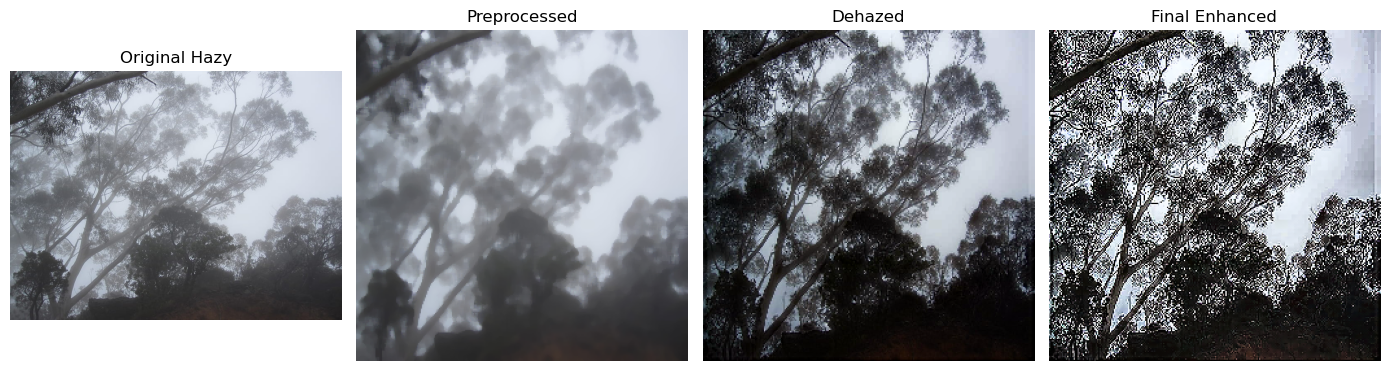

In [84]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\HD-wallpaper-hazed-beauty-haze-grey-trees-branches-sky.jpg", model, device)


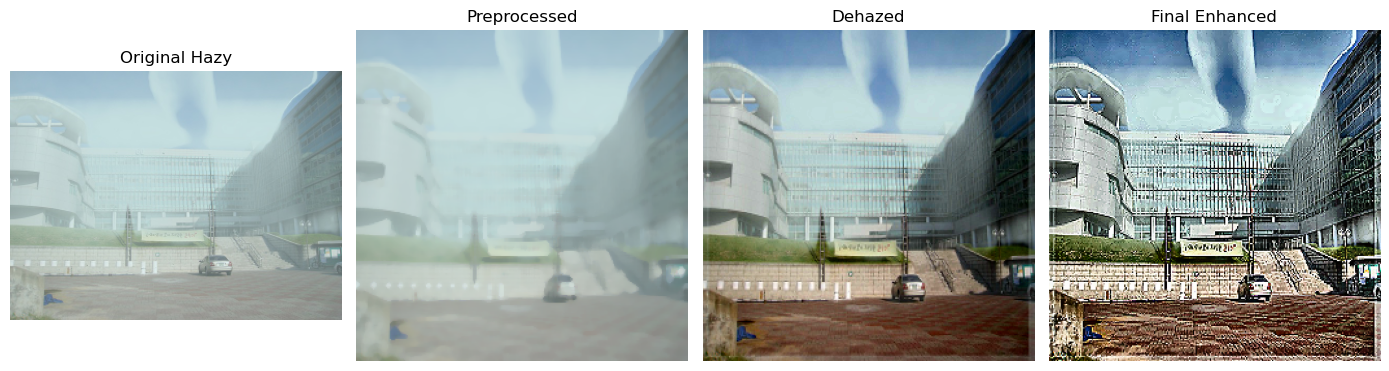

In [86]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\buildinghazed.jpg", model, device)


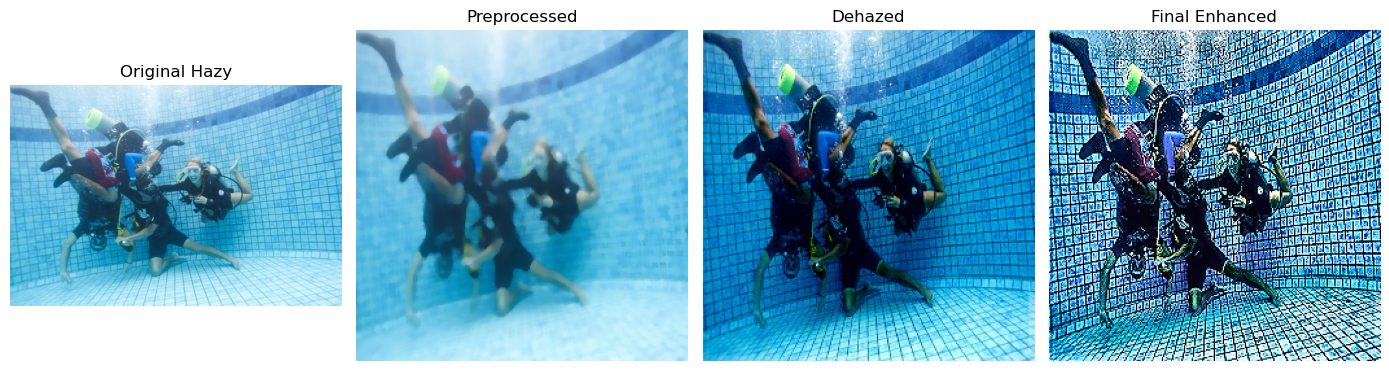

In [88]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\Hazing_01.jpg", model, device)


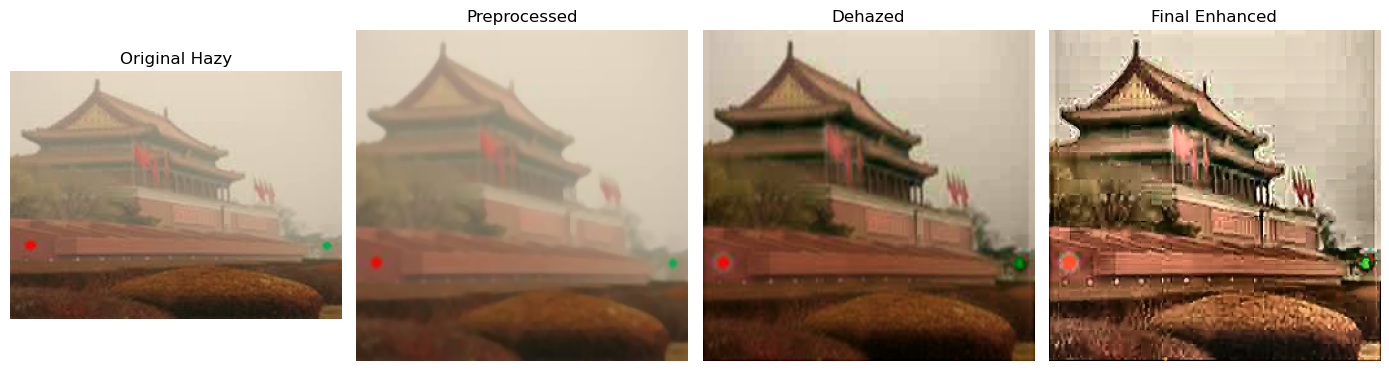

In [90]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\hazedimg.jpg", model, device)


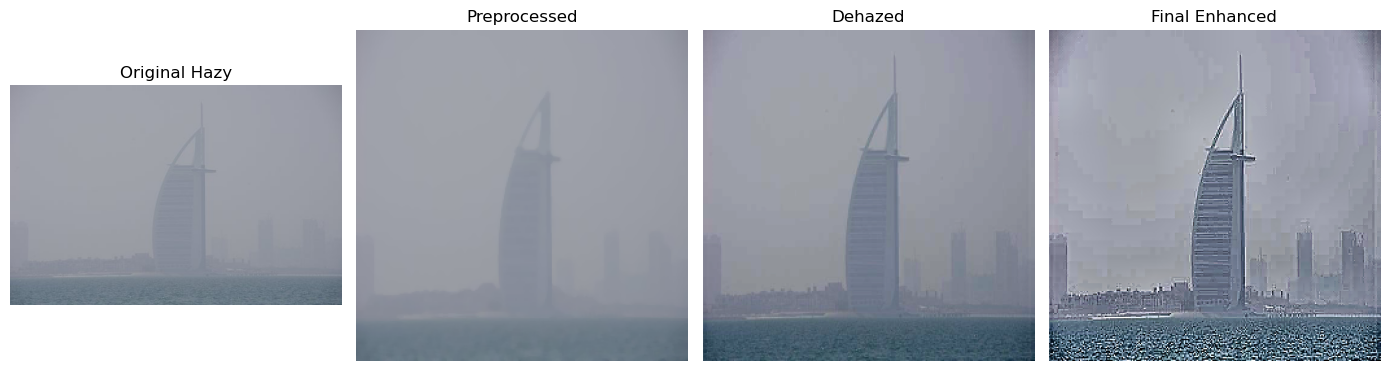

In [92]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\heat-hazed-dubai-attractions.jpg", model, device)
